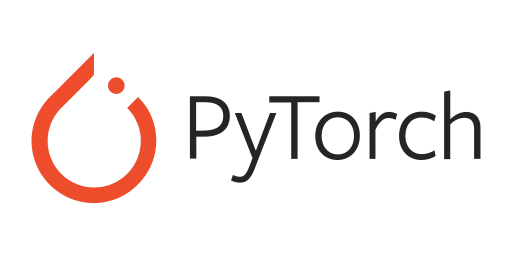

In [1]:
import torch
torch.__version__

'1.11.0+cu113'

In [79]:
import torch.nn as nn
import torch.nn.functional as F

## 선형 회귀 모델(Linear Regression Model)

### 데이터 생성

### 모델 정의 및 파라미터

### 손실 함수 및 옵티마이저

### 모델 학습

## FashionMNIST 분류 모델

GPU 설정

### 데이터 로드

### 모델 정의 및 파라미터

### 손실함수와 옵티마이저

### 모델 학습

배치수 확인

### 모델의 저장 및 로드

- `torch.save`: `net.state_dict()`를 저장
- `torch.load`: `load_state_dict`로 모델을 로드

### 모델 테스트